In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [23]:
from src import *
from problems import *
from scipy.spatial import cKDTree

In [24]:
#-- PARAMETERS --#

N = 6400
K = 25
l = 4
kappa = 3
delta = 1e-5
l_grad = 3
K_grad = 20

np.random.seed(0)

In [25]:
#-- GEOMETRY --#

theta, phi = sp.symbols('theta phi', real=True)
R = 2.0
r = 1.0

x_sym = (R + r * sp.cos(theta)) * sp.cos(phi)
y_sym = (R + r * sp.cos(theta)) * sp.sin(phi)
z_sym = r * sp.sin(theta)

manifold = Manifold([theta, phi], [x_sym, y_sym, z_sym])
manifold.compute()

theta_range = (0, 2*np.pi)
phi_range = (0, np.pi)
# phi_range = (np.pi / 9, 8 * np.pi / 9)

phi_min = phi_range[0]
phi_max = phi_range[1]

num_boundary = 2 * int(np.round(np.sqrt(2*r/R)*np.sqrt(N)))
# num_boundary = 2 * int(np.round(np.sqrt(2*r*9/(R*7))*np.sqrt(N))) # TODO: adaptive code
num_interior = N - num_boundary

manifold.sample([theta_range, phi_range], num_interior)

# sample boundary

x_sym_left = (R + r * sp.cos(theta)) * sp.cos(phi_min)
y_sym_left = (R + r * sp.cos(theta)) * sp.sin(phi_min)

boundary_left = Manifold([theta], [x_sym_left, y_sym_left, z_sym])
boundary_left.sample([theta_range], num_boundary // 2)

x_sym_right = (R + r * sp.cos(theta)) * sp.cos(phi_max)
y_sym_right = (R + r * sp.cos(theta)) * sp.sin(phi_max)

boundary_right = Manifold([theta], [x_sym_right, y_sym_right, z_sym])
boundary_right.sample([theta_range], num_boundary // 2)

manifold.params = np.vstack([
    manifold.params,
    np.insert(boundary_left.params, 1, values=phi_min, axis=1),
    np.insert(boundary_right.params, 1, values=phi_max, axis=1)
])

manifold.points = np.vstack([
    manifold.points,
    boundary_left.points,
    boundary_right.points
])

id_interior = np.arange(num_interior)
id_boundary = np.arange(num_interior, N)

In [26]:
#-- MANUFACTURED SOLUTION --#

u_sym = sp.sin(theta) * sp.cos(phi + sp.pi/4)

u_lap_sym = manifold.get_laplacian(u_sym)
u_grad_sym = manifold.get_gradient(u_sym)
f_sym = -u_lap_sym

tt = manifold.params[:, 0]
pp = manifold.params[:, 1]

f_func = sp.lambdify((theta, phi), f_sym, 'numpy')
f_vals = f_func(tt, pp)

u_func = sp.lambdify((theta, phi), u_sym, 'numpy')
u_vals = u_func(tt, pp)

u_lap_func = sp.lambdify((theta, phi), u_lap_sym, 'numpy')
u_lap_vals = u_lap_func(tt, pp)

u_grad_func = sp.lambdify((theta, phi), u_grad_sym, 'numpy')
u_grad_vals = u_grad_func(tt, pp) # shape: (n, 1, N)

u_grad_vals_boundary = u_grad_vals.squeeze()[:, id_boundary].T # shape: (num_boundary, n)

# outward normal at each boundary point
n_vecs = np.zeros((num_boundary, manifold.n)) # shape: (num_boundary, n)

for i in range(num_boundary):
    n_vecs[i, :] = [0.0, -1.0, 0.0]

g_vals = u_vals[id_boundary] + np.sum(n_vecs * u_grad_vals_boundary, axis=1) # shape: (num_boundary)

In [27]:
good_weights_list = []
pos_weights_list = []
ill_weights_list = [] # ratio < 1.0
fixed_weights_list = []

In [28]:
#-- LAPLACIAN --#

L = np.zeros((num_interior, N))
tree_full = cKDTree(manifold.points)

bad_count = 0
for i, i_id in enumerate(id_interior):
    # auto K
    K_current = K
    max_K_retries = 15

    K_retries = 0

    best_ratio = -1.0
    best_weights = None
    best_stencil_ids = None

    while True:
        _, stencil_ids = tree_full.query(manifold.points[i_id], K_current)

        weights_lap = get_operator_weights(
            stencil=manifold.points[stencil_ids],
            tangent_basis=manifold.get_local_basis(manifold.params[i])[0],
            operator='lap',
            kappa=kappa,
            l=l,
            delta=delta,
        ) # shape: (1, K)

        if K_current == K:
            initial_weights = weights_lap.copy()
            initial_stencil_ids = stencil_ids.copy()

        w_center = weights_lap[0, 0]
        w_neighbors = weights_lap[0, 1:]
        
        is_positive = w_center > 0.0
        
        # ratio = |w_center| / max(|w_neighbors|)
        ratio = np.abs(w_center) / np.max(np.abs(w_neighbors))
        
        is_unstable = ratio < 3.0

        # record best
        if not is_positive:
            if ratio > best_ratio:
                best_ratio = ratio
                best_weights = weights_lap.copy()
                best_stencil_ids = stencil_ids.copy()

        if not is_positive and not is_unstable:
            #### record good weights
            good_weights_list.append((i_id, weights_lap.flatten()))
            ####
            break

        if K_retries < max_K_retries:
            K_current += 2
            K_retries += 1
        else:
            break

    if best_weights is None:
        weights_lap = initial_weights
        stencil_ids = initial_stencil_ids
    else:
        weights_lap = best_weights
        stencil_ids = best_stencil_ids

    # detecting bad weights
    w_center = weights_lap[0, 0]
    w_neighbors = weights_lap[0, 1:]
    
    is_positive = w_center > 0.0
    
    # ratio = |w_center| / max(|w_neighbors|)
    ratio = np.abs(w_center) / np.max(np.abs(w_neighbors))
    
    is_unstable = ratio < 1.0

    #### record ill weights
    if is_positive:
        pos_weights_list.append((i_id, weights_lap.flatten()))
    elif is_unstable:
        ill_weights_list.append((i_id, weights_lap.flatten()))
    ####

    if is_positive or is_unstable:
        
        # qp
        K_current = K # fixed to initial K
        max_K_retries = 15

        K_retries = 0

        best_ratio = -1.0
        best_weights = None
        best_stencil_ids = None

        while True:
            _, stencil_ids = tree_full.query(manifold.points[i_id], K_current)

            weights_lap = get_operator_weights(
                stencil=manifold.points[stencil_ids],
                tangent_basis=manifold.get_local_basis(manifold.params[i])[0],
                operator='lap',
                kappa=kappa,
                l=l,
                delta=delta,
                qp=True
            )

            if weights_lap is not None:
                # detecting bad weights
                w_center = weights_lap[0, 0]
                w_neighbors = weights_lap[0, 1:]
                
                is_positive = w_center > 0.0
                
                # ratio = |w_center| / max(|w_neighbors|)
                ratio = np.abs(w_center) / np.max(np.abs(w_neighbors))
                
                is_unstable = ratio < 1.0

                if not is_positive:
                    if ratio > best_ratio:
                        best_ratio = ratio
                        best_weights = weights_lap.copy()
                        best_stencil_ids = stencil_ids.copy()

                if not is_positive and not is_unstable:
                    break

            if K_retries < max_K_retries:
                K_current += 2
                K_retries += 1
            else:
                break

        if best_weights is None:
            raise RuntimeError("operator sign error")
        else:
            weights_lap = best_weights
            stencil_ids = best_stencil_ids

        #### record ill weights
        fixed_weights_list.append((i_id, weights_lap.flatten()))
        ####

    L[i, stencil_ids] = weights_lap[0, :]

In [29]:
fe_interior = np.abs(L @ u_vals - u_lap_vals[id_interior])
fe_interior_l2 = np.sqrt(np.sum(fe_interior ** 2) / num_interior)
fe_interior_max = np.max(fe_interior)

print('Interior FE')
print(f'L2: {fe_interior_l2:.3e} MAX: {fe_interior_max:.3e}')

Interior FE
L2: 5.782e-04 MAX: 2.831e-02


In [30]:
#-- GRADIENT --#
D_n = np.zeros((num_boundary, N))
tree_interior = cKDTree(manifold.points[id_interior])

for i, b_id in enumerate(id_boundary):
    # auto K
    K_current = K_grad
    max_K_retries = 15

    K_retries = 0

    best_ratio = -1.0
    best_weights = None
    best_stencil_ids = None
    while True:
        _, stencil_ids = tree_interior.query(manifold.points[b_id], K_current-1)

        # append boundary point
        stencil_points = np.vstack((manifold.points[b_id], manifold.points[stencil_ids]))
        stencil_ids = np.append(b_id, stencil_ids)

        weights_grad = get_operator_weights(
            stencil=stencil_points,
            tangent_basis=manifold.get_local_basis(manifold.params[b_id])[0],
            operator='grad',
            kappa=kappa,
            l=l_grad,
            delta=delta,
        ) # shape: (n, K)

        n_vec = n_vecs[i]
        weights_grad_n = n_vec @ weights_grad # shape: (K,)

        if K_current == K_grad:
            initial_weights = weights_grad_n.copy()
            initial_stencil_ids = stencil_ids.copy()

        w_center = weights_grad_n[0]
        w_neighbors = weights_grad_n[1:]
        
        is_positive = w_center > 0.0
        
        # ratio = |w_center| / max(|w_neighbors|)
        ratio = np.abs(w_center) / np.max(np.abs(w_neighbors))
        
        is_unstable = ratio < 3.0

        if is_positive:
            if ratio > best_ratio:
                best_ratio = ratio
                best_weights = weights_grad_n.copy()
                best_stencil_ids = stencil_ids.copy()

        if is_positive and not is_unstable: # for gradient, we need positive
            break

        if K_retries < max_K_retries:
            K_current += 2
            K_retries += 1
        else:
            break
    
    if best_weights is None:
        print('Warning: operator wrong sign')
        weights_grad_n = initial_weights
        stencil_ids = initial_stencil_ids
    else:
        weights_grad_n = best_weights
        stencil_ids = best_stencil_ids

    D_n[i, stencil_ids] = weights_grad_n

In [31]:
fe_boundary = np.abs(D_n @ u_vals - np.sum(n_vecs * u_grad_vals_boundary, axis=1))
fe_boundary_l2 = np.sqrt(np.sum(fe_boundary ** 2) / num_boundary)
fe_boundary_max = np.max(fe_boundary)

print('Boundary FE')
print(f'L2: {fe_boundary_l2:.3e} MAX: {fe_boundary_max:.3e}')

Boundary FE
L2: 3.896e-04 MAX: 1.159e-03


In [32]:
#-- SYSTEM PARTITION --#
A = -L
A_II = A[:, id_interior]
A_IB = A[:, id_boundary]

B_BI = D_n[:, id_interior] # interior points do not affect the Dirichlet part
B_BB = D_n[:, id_boundary] + np.eye(num_boundary) 

f_I = f_vals[id_interior]
g_B = g_vals

# Schur complement
B_BB_inv = np.linalg.inv(B_BB)

A_prime = A_II - A_IB @ B_BB_inv @ B_BI
b_prime = f_I - A_IB @ (B_BB_inv @ g_B)

u_num_interior = np.linalg.solve(A_prime, b_prime)
# u_num_interior = np.zeros(num_interior)
u_num_boundary = B_BB_inv @ (g_B - B_BI @ u_num_interior)

u_num = np.zeros(N)
u_num[id_interior] = u_num_interior
u_num[id_boundary] = u_num_boundary

In [33]:
ie = np.abs(u_num - u_vals) # shape: (N,)
ie_l2 = np.sqrt(np.sum(ie ** 2) / N)
ie_max = np.max(ie)

print('IE')
print(f'L2: {ie_l2:.3e} MAX: {ie_max:.3e}')

IE
L2: 6.349e-05 MAX: 2.889e-04


In [34]:
import matplotlib.pyplot as plt

In [35]:
good_weights = good_weights_list[0][1]
pos_weights = pos_weights_list[2][1]
fixed_weights = fixed_weights_list[11][1]
ill_weights = ill_weights_list[0][1]
fixed_ill_weights = fixed_weights_list[0][1]

In [36]:
#-- PLOT WEIGHTS --#
def plot_weights(weights, filename=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    
    ids = np.arange(len(weights))
    bars = ax.bar(ids, weights)
    bars[0].set_color('red')

    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    ax.set_xlabel('nearest neighbors indices')
    ax.set_ylabel('weights')
    plt.tight_layout()

    if filename is not None:
        fig.savefig(f'./static/{filename}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

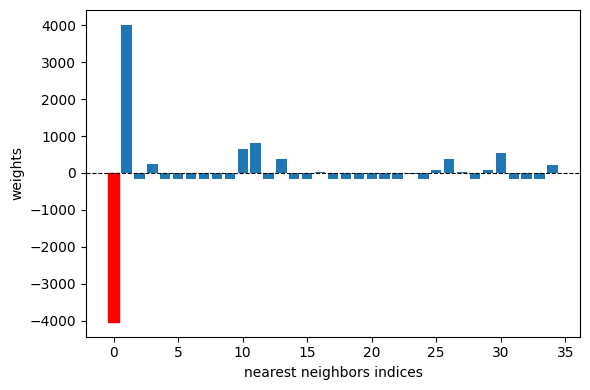

In [37]:
plot_weights(fixed_ill_weights, filename='fixed_ill_weights')

In [90]:
def plot_bad_points(params, pos_idx, ill_idx, filename=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    pos_points = params[pos_idx]
    ill_points = params[ill_idx]
    
    ax.scatter(
        params[:, 0], params[:, 1],
        s=10,
        c='gray',
        marker='o',
        edgecolors='none',
        alpha=0.1
    )

    ax.scatter(pos_points[:, 0], pos_points[:, 1], label=r'$w_0$ > 0',
               c='red', marker='x', s=120, alpha=1.0, zorder=5)
    

    ax.scatter(ill_points[:, 0], ill_points[:, 1], label='ratio < 1.0',
               edgecolors='blue', marker='o', s=60, alpha=0.9, facecolors='none',
              zorder=5)
    
    ax.set_xlim(0.0, 2*np.pi)
    ax.set_ylim(0.0, np.pi)

    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\phi$')

    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_xticks([0, np.pi/2, np.pi, 3 * np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

    ax.legend()

    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    plt.tight_layout()
    if filename is not None:
        fig.savefig(f'./static/{filename}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [39]:
pos_idx = []
ill_idx = []
for pos_weights_tuple in pos_weights_list:
    pos_idx.append(pos_weights_tuple[0])
for ill_weights_tuple in ill_weights_list:
    ill_idx.append(ill_weights_tuple[0])

In [40]:
pos_idx_qp = []
ill_idx_qp = []

for fixed_weights_tuple in fixed_weights_list:
    idx = fixed_weights_tuple[0]
    weights = fixed_weights_tuple[1]

    center = weights[0]
    neighbors = weights[1:]
    ratio = np.abs(center) / np.max(np.abs(neighbors))

    if center > 0.0:
        pos_idx_qp.append(idx)
    elif ratio < 1.0:
        ill_idx_qp.append(idx)

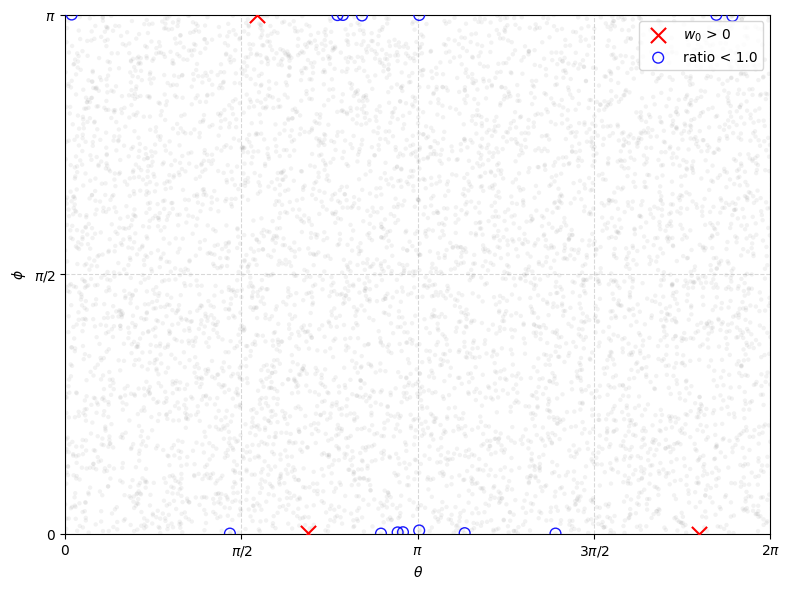

In [94]:
plot_bad_points(manifold.params[id_interior], pos_idx, ill_idx, filename='bad_points')

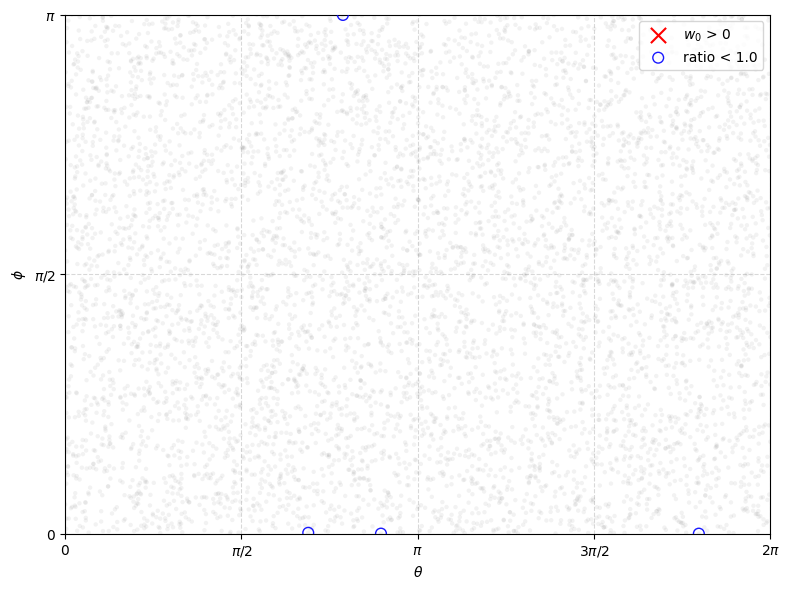

In [ ]:
plot_bad_points(manifold.params[id_interior], pos_idx_qp, ill_idx_qp, filename='./static/bad_points_qp')

In [43]:
fe_interior_plot = fe_interior.copy()
fe_boundary_plot = fe_boundary.copy()

In [49]:
# test fe consistency with l=2/3/4/5
N_vals = [1600, 3200, 6400, 12800, 25600]
l_vals = [2, 3, 4, 5]
K_vals = [15, 20, 25, 30]
seeds = np.arange(4)

fe_interior_arr = np.zeros((len(N_vals), len(seeds), len(l_vals)))
fe_boundary_arr = np.zeros((len(N_vals), len(seeds), len(l_vals)))

for i, N in enumerate(N_vals):
    for j, seed in enumerate(seeds):
        for k in range(len(l_vals)):
            l = l_vals[k]
            K = K_vals[k]
            l_grad = l_vals[k]
            K_grad = K_vals[k]

            fe_interior, fe_boundary, _ = poisson_robin_semi_torus(N=N, K=K, l=l, K_grad=K_grad, l_grad=l_grad, seed=seed)
            fe_interior_l2 = np.sqrt(np.sum(fe_interior ** 2) / len(fe_interior))
            fe_boundary_l2 = np.sqrt(np.sum(fe_boundary ** 2) / len(fe_boundary))

            print(f'{N} | {seed} | {l} | {fe_interior_l2:.3e} | {fe_boundary_l2:.3e}')

            fe_interior_arr[i, j, k] = fe_interior_l2
            fe_boundary_arr[i, j, k] = fe_boundary_l2

1600 | 0 | 2 | 1.256e-02 | 5.746e-03
1600 | 0 | 3 | 1.299e-02 | 3.669e-03
1600 | 0 | 4 | 4.710e-03 | 6.461e-03
1600 | 0 | 5 | 1.145e-02 | 1.242e-02
1600 | 1 | 2 | 1.557e-02 | 5.792e-03
1600 | 1 | 3 | 8.398e-03 | 5.652e-03
1600 | 1 | 4 | 5.860e-03 | 8.323e-03
1600 | 1 | 5 | 7.059e-03 | 1.855e-02
1600 | 2 | 2 | 2.025e-02 | 6.943e-03
1600 | 2 | 3 | 6.639e-03 | 7.998e-03
1600 | 2 | 4 | 6.764e-03 | 9.847e-03
1600 | 2 | 5 | 1.419e-02 | 2.241e-02
1600 | 3 | 2 | 1.629e-02 | 4.678e-03
1600 | 3 | 3 | 1.269e-02 | 4.431e-03
1600 | 3 | 4 | 6.015e-03 | 8.203e-03
1600 | 3 | 5 | 7.130e-03 | 1.358e-02
3200 | 0 | 2 | 1.061e-02 | 1.823e-03
3200 | 0 | 3 | 6.449e-03 | 1.094e-03
3200 | 0 | 4 | 4.887e-03 | 1.387e-03
3200 | 0 | 5 | 2.005e-03 | 1.764e-03
3200 | 1 | 2 | 1.074e-02 | 2.213e-03
3200 | 1 | 3 | 7.024e-03 | 1.188e-03
3200 | 1 | 4 | 2.348e-03 | 1.279e-03
3200 | 1 | 5 | 2.070e-03 | 1.432e-03
3200 | 2 | 2 | 9.846e-03 | 1.763e-03
3200 | 2 | 3 | 8.592e-03 | 1.339e-03
3200 | 2 | 4 | 2.585e-03 | 1.803e-03
3

In [89]:
np.save('./results/fe_interior_arr.npy', fe_interior_arr)
np.save('./results/fe_boundary_arr.npy', fe_boundary_arr)

In [86]:
def plot_convergence(error_arr, filename=None):
    N_vals = np.array([1600, 3200, 6400, 12800, 25600])
    fig, ax = plt.subplots(figsize=(9, 8))

    err_mean = np.mean(error_arr, axis=1)
    err_std = np.std(error_arr, axis=1)

    for k, l_val in enumerate(l_vals):
        means = err_mean[:, k]
        stds = err_std[:, k]
        
        line, = plt.loglog(N_vals, means, marker='o', label=f'l = {l_val}')
        
        color = line.get_color()
        
        plt.fill_between(
            N_vals, 
            means - stds, 
            means + stds, 
            color=color, 
            alpha=0.2,
            edgecolor=None
        )

    # convergence ref
    def plot_ref_line(anchor, slope, label):
        N0, E0 = anchor
        C = E0 / (N0 ** slope)
        ref_line = C * (N_vals ** slope)

        ax.plot(N_vals, ref_line, 'k--', linewidth=0.5,)

        ax.annotate(
            label, 
            xy=anchor,
            xytext=(50, -10),
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize=10,
        )

    plot_ref_line((1600, 2e-3), -3.0, r'$O(N^{-3})$')
    plot_ref_line((1600, 3e-2), -1.0, r'$O(N^{-1})$')

    ax.set_xticks(N_vals)
    ax.set_xticklabels(N_vals)
    ax.minorticks_off()

    ax.set_xlabel(r'$N$')
    ax.set_ylabel('FE')

    ax.legend()

    if filename is not None:
        fig.savefig(f'./static/{filename}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

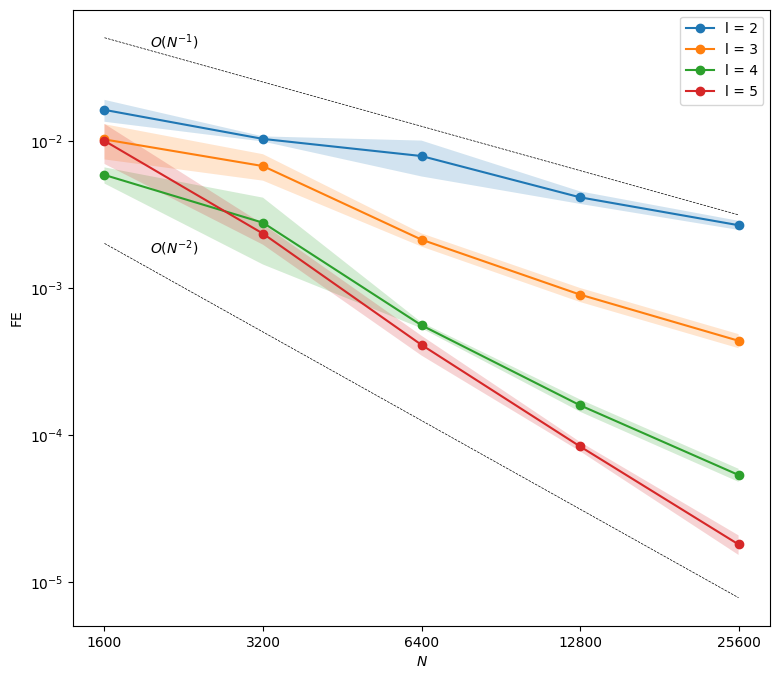

In [85]:
plot_convergence(fe_interior_arr, filename='fe_interior')

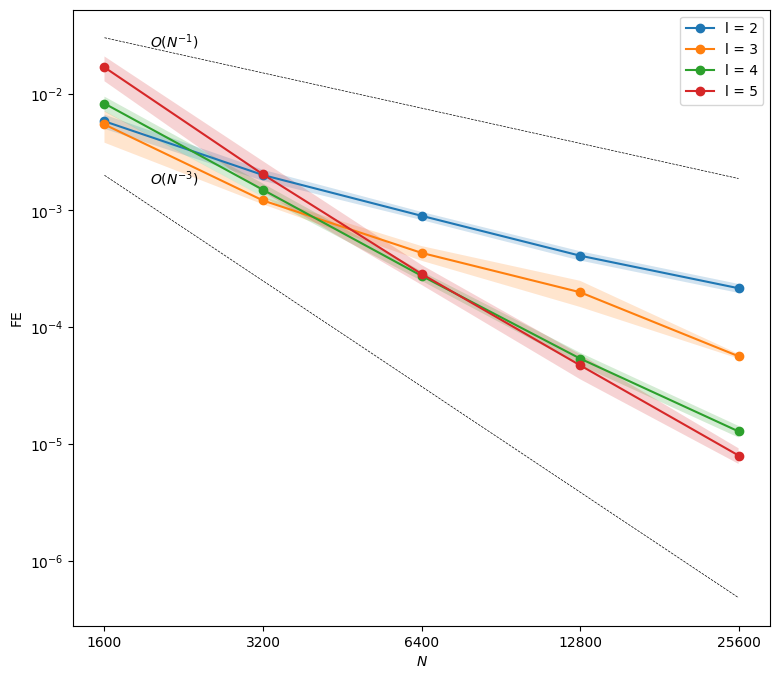

In [88]:
plot_convergence(fe_boundary_arr, filename='fe_boundary')

In [95]:
from matplotlib.colors import LogNorm

In [108]:
def plot_error_distribution(params, error_vals, filename=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sc = ax.scatter(
        params[:, 0], params[:, 1], c=error_vals,
        s=100,
        cmap='jet', 
        norm=LogNorm(),
        marker='o',
        edgecolors='none',
        alpha=0.8
    )

    # find the point with maximum error
    max_id = np.argmax(error_vals)
    ax.scatter(params[max_id][0], params[max_id][1], s=100, facecolors='none', edgecolors='black', linewidth=2)

    max_err_text = f"{error_vals[max_id]:.3e}"

    ax.annotate(
        max_err_text, 
        xy=(params[max_id][0], params[max_id][1]),
        xytext=(0, -20),
        textcoords='offset points',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10,
        fontweight='bold'
    )

    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Forward Error', rotation=270, labelpad=20)

    ax.set_xlim(0.0, 2*np.pi)
    ax.set_ylim(0.0, np.pi)

    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels([r'$0$', r'$\pi/2$', r'$\pi$'])
    ax.set_xticks([0, np.pi/2, np.pi, 3 * np.pi/2, 2*np.pi])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$\phi$', rotation=0)
    ax.grid(True, linestyle='--', alpha=0.3, color='gray')
    # ax.set_aspect('equal')

    ax.minorticks_off()

    if filename is not None:
        fig.savefig(f'./static/{filename}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

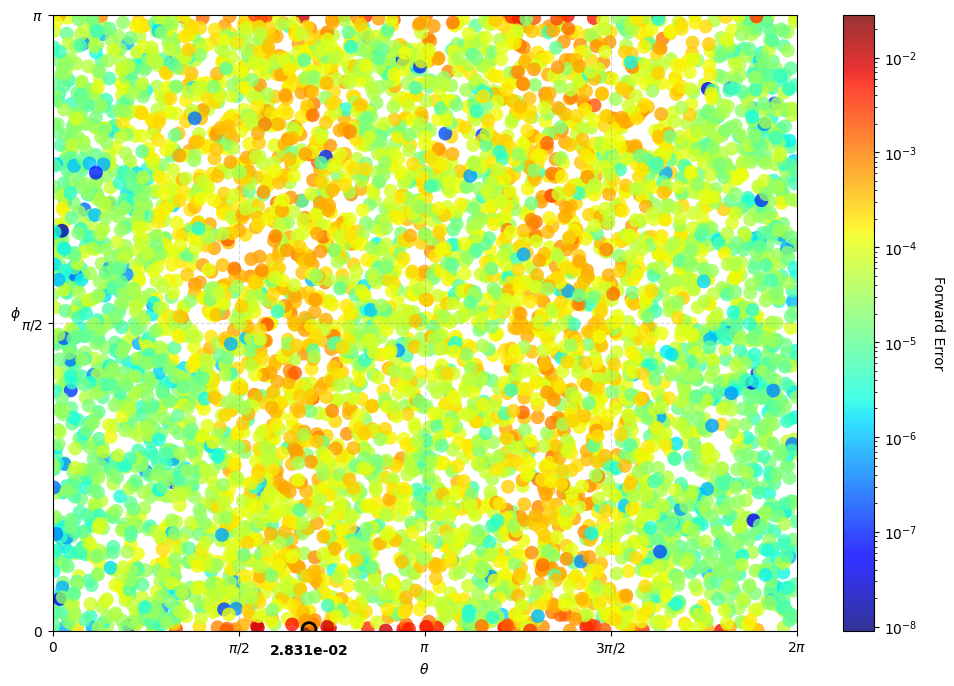

In [109]:
plot_error_distribution(manifold.params[id_interior], fe_interior_plot, filename='fe_interior_pointwise')

In [ ]:
# test ie convergence with l_grad=2/3/4/5
N_vals = [1600, 3200, 6400, 12800, 25600]
l_vals = [2, 3, 4, 5]
K_vals = [15, 20, 25, 30]
seeds = np.arange(4)

ie_arr = np.zeros((len(N_vals), len(seeds), len(l_vals)))
ie_max_arr = np.zeros((len(N_vals), len(seeds), len(l_vals)))

for i, N in enumerate(N_vals):
    for j, seed in enumerate(seeds):
        for k in range(len(l_vals)):
            l_grad = l_vals[k]
            K_grad = K_vals[k]

            ie = poisson_robin_semi_torus(N=N, K_grad=K_grad, l_grad=l_grad, seed=seed)
            ie_l2 = np.sqrt(np.sum(ie ** 2) / N)
            ie_max = np.max(ie)

            print(f'{N} | {seed} | {l} | {ie_l2:.3e} | {ie_max:.3e}')

            ie_arr[i, j, k] = ie_l2
            ie_max_arr[i, j, k] = ie_max